## 분석하면서 생각한 핵심포인트
  - train[family_size] > 7 인 이상치 제거
  - 중복 데이터 처리를 위해 개인정보를 모두 합쳐 ID 변수 생성
  (단, 같은 사용자가 여러번 카드를 발급할 수 있다는 가정 하에 begin_month는 개인정보에서 제외함)
  - 개인의 특성이 될 만한 파생변수 추가 
  - Catboost 모델 사용

In [1]:
# 이거는 colab에서 먼저 설치해주세요! 
#!pip install catboost
#!pip install category_encoders

## 라이브러리 불러오기 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

# pip install optuna 
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier, Pool


## 데이터 불러오기

In [2]:
import os
os.chdir('C:/Temp/')

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

## 데이터 전처리

### 1. 이상치 처리
-  train['family_size'] > 7 인 데이터 제거

In [4]:
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

## Feature Engineering

### 1. 의미없는 변수 제거
- index 제거
- FLAG_MOBIL 삭제:모든 값이 1로 동일 
- occyp_type 삭제: 결측값 8171개 

In [5]:
train.drop(['index', 'FLAG_MOBIL', 'occyp_type'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL', 'occyp_type'], axis=1, inplace=True)

### 2. DAYS_EMPLOYED 
- 양수인 데이터는 현재 무직자로 판단, 0 처리

In [6]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

### 3. DAYS_BIRTH, begin_month, DAYS_EMPLOYED
-  음수값 -> 양수 변환

In [7]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

### 4. 파생변수

In [8]:
for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    
    #Age(나이)
    df['Age'] = df['DAYS_BIRTH'] // 365
   
    #EMPLOYED(근속연수)  
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']
    
    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str)


In [9]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,family_size,begin_month,credit,before_EMPLOYED,income_total_befofeEMP_ratio,Age,EMPLOYED,ability,income_mean,ID
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,...,2.0,6.0,1.0,9190,22.034820,38,12,10.882416,101250.0,0_202500.0_13899_4709_0_0_0_2.0_F_N_N_Commerci...
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,...,3.0,5.0,1.0,9840,25.152439,31,4,19.156347,82500.0,1_247500.0_11380_1540_0_0_1_3.0_F_N_Y_Commerci...
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,...,2.0,22.0,2.0,14653,30.710435,52,12,19.131840,225000.0,0_450000.0_19087_4434_0_1_0_2.0_M_Y_Y_Working_...
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,...,2.0,37.0,0.0,12996,15.581717,41,5,11.786962,101250.0,0_202500.0_15088_2092_0_1_0_2.0_F_N_Y_Commerci...
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,...,2.0,26.0,2.0,12932,12.179091,41,5,9.187959,78750.0,0_157500.0_15037_2105_0_0_0_2.0_F_Y_Y_State se...


### 5. 파생변수와 다중공선성을 보이는 컬럼 삭제

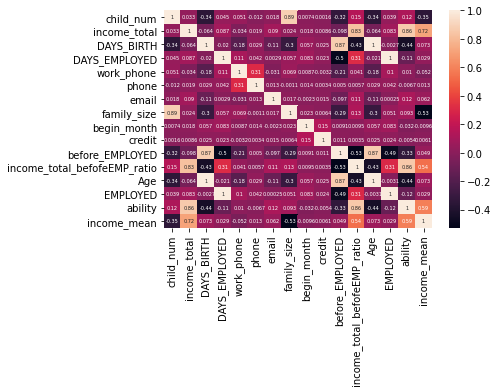

In [49]:
sns.heatmap(train.corr(), annot=True, annot_kws = {"size": 5})
plt.rcParams["figure.figsize"] = [12, 9]
plt.rcParams["figure.dpi"] = 200
plt.show()

In [9]:
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

## Scaling, Encoding

### 1. Numeric, Category 컬럼 분류

In [10]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  12
Number of Categorical features:  8


In [13]:
numerical_feats

['income_total',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'before_EMPLOYED',
 'income_total_befofeEMP_ratio',
 'Age',
 'EMPLOYED',
 'ability',
 'income_mean']

In [14]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'ID']

### 2. Log Scale
- income_total

In [11]:
# 원래 income_total 분포 꼬리가 길어서 로그변환 
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

### 3. OrdinalEncoder 
- 카테고리 변수는 ordinal_encoder 변환 
- ID는 변환 후 정수 처리



In [12]:
# 카테고리 변수 모두 encoding하고 ID 변수만 추가로 정수 처리 
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

In [17]:
train.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,...,family_size,begin_month,credit,before_EMPLOYED,income_total_befofeEMP_ratio,Age,EMPLOYED,ability,income_mean,ID
0,1,1,1,12.218505,1,1,1,1,0,0,...,2.0,6.0,1.0,9190,22.034820,38,12,10.882416,101250.0,1
1,1,1,2,12.419174,1,2,2,2,0,0,...,3.0,5.0,1.0,9840,25.152439,31,4,19.156347,82500.0,2
2,2,2,2,13.017007,2,1,1,2,0,1,...,2.0,22.0,2.0,14653,30.710435,52,12,19.131840,225000.0,3
3,1,1,2,12.218505,1,2,1,2,0,1,...,2.0,37.0,0.0,12996,15.581717,41,5,11.786962,101250.0,4
4,1,2,2,11.967193,3,1,1,2,0,0,...,2.0,26.0,2.0,12932,12.179091,41,5,9.187959,78750.0,5


In [13]:
# length를 보면 unique한 사람은 8756명 
train['ID'].value_counts()

131     35
386     24
728     24
1493    21
1014    20
        ..
7689     1
7607     1
5558     1
3611     1
2047     1
Name: ID, Length: 8756, dtype: int64

### 4. 클러스터링 구성
- 타겟을 결정짓는 뚜렷한 특징을 갖는 피쳐를 찾지 못해 clustering 시도

In [14]:
# 데이터를 36개의 cluster로 분류하여 넘버링 
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

### 5. StandardScale
- 이미 로그변환을 진행한 income_total을 제외한 나머지 numeric 컬럼 정규화

In [15]:
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

In [21]:
###########################################################################################################

## Modeling 

In [16]:
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

### 1. ModelSelection

In [17]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [24]:
print(train_x.shape, train_y.shape, test.shape)

(26451, 21) (26451, 1) (10000, 21)


In [ ]:
#pip install --user pycaret

In [59]:
from sklearn.metrics import log_loss
from pycaret.classification import *

clf = setup(train, target = 'credit', train_size = 0.85)

,Description,Value
0,session_id,4540
1,Target,credit
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(26451, 22)"
5,Missing Values,False
6,Numeric Features,18
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [60]:
#logloss 적용 및 predict_proba로 제출하기 위해 metric 추가
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

Name                                                           LogLoss
Display Name                                                   LogLoss
Score Function               <function log_loss at 0x0000024A27DCDD30>
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: logloss, dtype: object

In [29]:
best5 = compare_models(fold = 5, sort = 'logloss', n_select = 5, exclude=['svm','ridge'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7088,0.7384,0.4760,0.6896,0.6586,0.3112,0.3598,0.7433,6.7940
lightgbm,Light Gradient Boosting Machine,0.7033,0.7296,0.4431,0.6997,0.6350,0.2661,0.3409,0.7493,1.4080
catboost,CatBoost Classifier,0.7047,0.7274,0.4587,0.6873,0.6464,0.2885,0.3455,0.7503,18.3100
gbc,Gradient Boosting Classifier,0.6910,0.6655,0.4126,0.6703,0.6073,0.2144,0.3020,0.7927,10.2740
lr,Logistic Regression,0.6413,0.6072,0.3359,0.5585,0.5037,0.0078,0.0494,0.8645,3.4460
lda,Linear Discriminant Analysis,0.6427,0.6071,0.3385,0.5606,0.5083,0.0157,0.0685,0.8645,0.1300
dummy,Dummy Classifier,0.6397,0.5000,0.3333,0.4093,0.4992,0.0000,0.0000,0.8845,0.0580
nb,Naive Bayes,0.6412,0.5897,0.3624,0.5265,0.5468,0.0806,0.1175,0.9220,0.0840
qda,Quadratic Discriminant Analysis,0.6356,0.5964,0.3772,0.5473,0.5619,0.1147,0.1389,0.9680,0.2300
rf,Random Forest Classifier,0.7008,0.7552,0.5509,0.6821,0.6875,0.3836,0.3880,1.0229,3.0180


### 2. RandomForest

+ HyperParameter Tuning

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
def rf_objective(trial):
    rf_params = {
        "criterion": trial.suggest_categorical("criterion",['gini', 'entropy']),
        "n_estimators": trial.suggest_int('n_estimators', 100, 500),
        "min_samples_split": trial.suggest_int('min_samples_split', 1, 100),
        "min_samples_leaf": trial.suggest_int('min_samples_leaf', 2, 100),
        "max_features": trial.suggest_discrete_uniform("max_features", 0.05,1,0.05),
        "oob_score": True,
        "random_state": 42,
        "n_jobs": -1,
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
    
    model_rf = RandomForestClassifier(**rf_params)
    
    model_rf.fit(X_train, y_train)    
    rf_pred = model_rf.predict_proba(X_valid)
    log_score = log_loss(y_valid, rf_pred)
    
    return log_score

In [20]:
sampler = TPESampler(seed=42)
rf_study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
rf_study.optimize(rf_objective, n_trials=10)
print("Best Score:", rf_study.best_value)
print("Best trial:", rf_study.best_trial.params)

[I 2022-01-27 14:46:07,038] A new study created in memory with name: rf_parameter_opt
[I 2022-01-27 14:46:19,471] Trial 0 finished with value: 0.7638591926314584 and parameters: {'criterion': 'entropy', 'n_estimators': 393, 'min_samples_split': 60, 'min_samples_leaf': 17, 'max_features': 0.2}. Best is trial 0 with value: 0.7638591926314584.
[I 2022-01-27 14:47:06,875] Trial 1 finished with value: 0.7474506858949658 and parameters: {'criterion': 'entropy', 'n_estimators': 341, 'min_samples_split': 71, 'min_samples_leaf': 4, 'max_features': 1.0}. Best is trial 1 with value: 0.7474506858949658.
[I 2022-01-27 14:47:14,604] Trial 2 finished with value: 0.7646976648086335 and parameters: {'criterion': 'gini', 'n_estimators': 172, 'min_samples_split': 19, 'min_samples_leaf': 32, 'max_features': 0.55}. Best is trial 1 with value: 0.7474506858949658.
[I 2022-01-27 14:47:27,155] Trial 3 finished with value: 0.7603491965431689 and parameters: {'criterion': 'gini', 'n_estimators': 345, 'min_sample

Best Score: 0.7126422489666344
Best trial: {'criterion': 'entropy', 'n_estimators': 135, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 0.35000000000000003}


+ RandomForest Train

In [21]:
params = {
        "criterion": "entropy",
        "n_estimators": 135,
        "min_samples_split": 20,
        "min_samples_leaf": 6,
        "max_features": 0.35000000000000003,
        "oob_score": True,
        "random_state": 42,
        "n_jobs": -1,
    }

In [22]:
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
splits = folds.split(X, y)
rf_oof = np.zeros((X.shape[0], 3))
rf_preds = np.zeros((X_test.shape[0], 3))

for fold, (train_idx, valid_idx) in enumerate(splits):
    print(f"============ Fold {fold} ============\n")
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    model_rf = RandomForestClassifier(**params)
    model_rf.fit(
        X_train,
        y_train,
    )

    rf_oof[valid_idx] = model_rf.predict_proba(X_valid)
    rf_preds += model_rf.predict_proba(X_test) / n_fold
    print(f"Log Loss Score: {log_loss(y_valid, rf_oof[valid_idx]):.5f}")

log_score = log_loss(y, rf_oof)
print(f"Log Loss Score: {log_score:.5f}")

============ Fold 0 ============

Log Loss Score: 0.68445
============ Fold 1 ============

Log Loss Score: 0.70509
============ Fold 2 ============

Log Loss Score: 0.71095
============ Fold 3 ============

Log Loss Score: 0.69346
============ Fold 4 ============

Log Loss Score: 0.70684
============ Fold 5 ============

Log Loss Score: 0.70748
============ Fold 6 ============

Log Loss Score: 0.69578
============ Fold 7 ============

Log Loss Score: 0.71216
============ Fold 8 ============

Log Loss Score: 0.71262
============ Fold 9 ============

Log Loss Score: 0.69624
============ Fold 10 ============

Log Loss Score: 0.70189
============ Fold 11 ============

Log Loss Score: 0.72687
============ Fold 12 ============

Log Loss Score: 0.69780
============ Fold 13 ============

Log Loss Score: 0.71790
============ Fold 14 ============

Log Loss Score: 0.70365
Log Loss Score: 0.70488


+ Feautre Importance

In [25]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

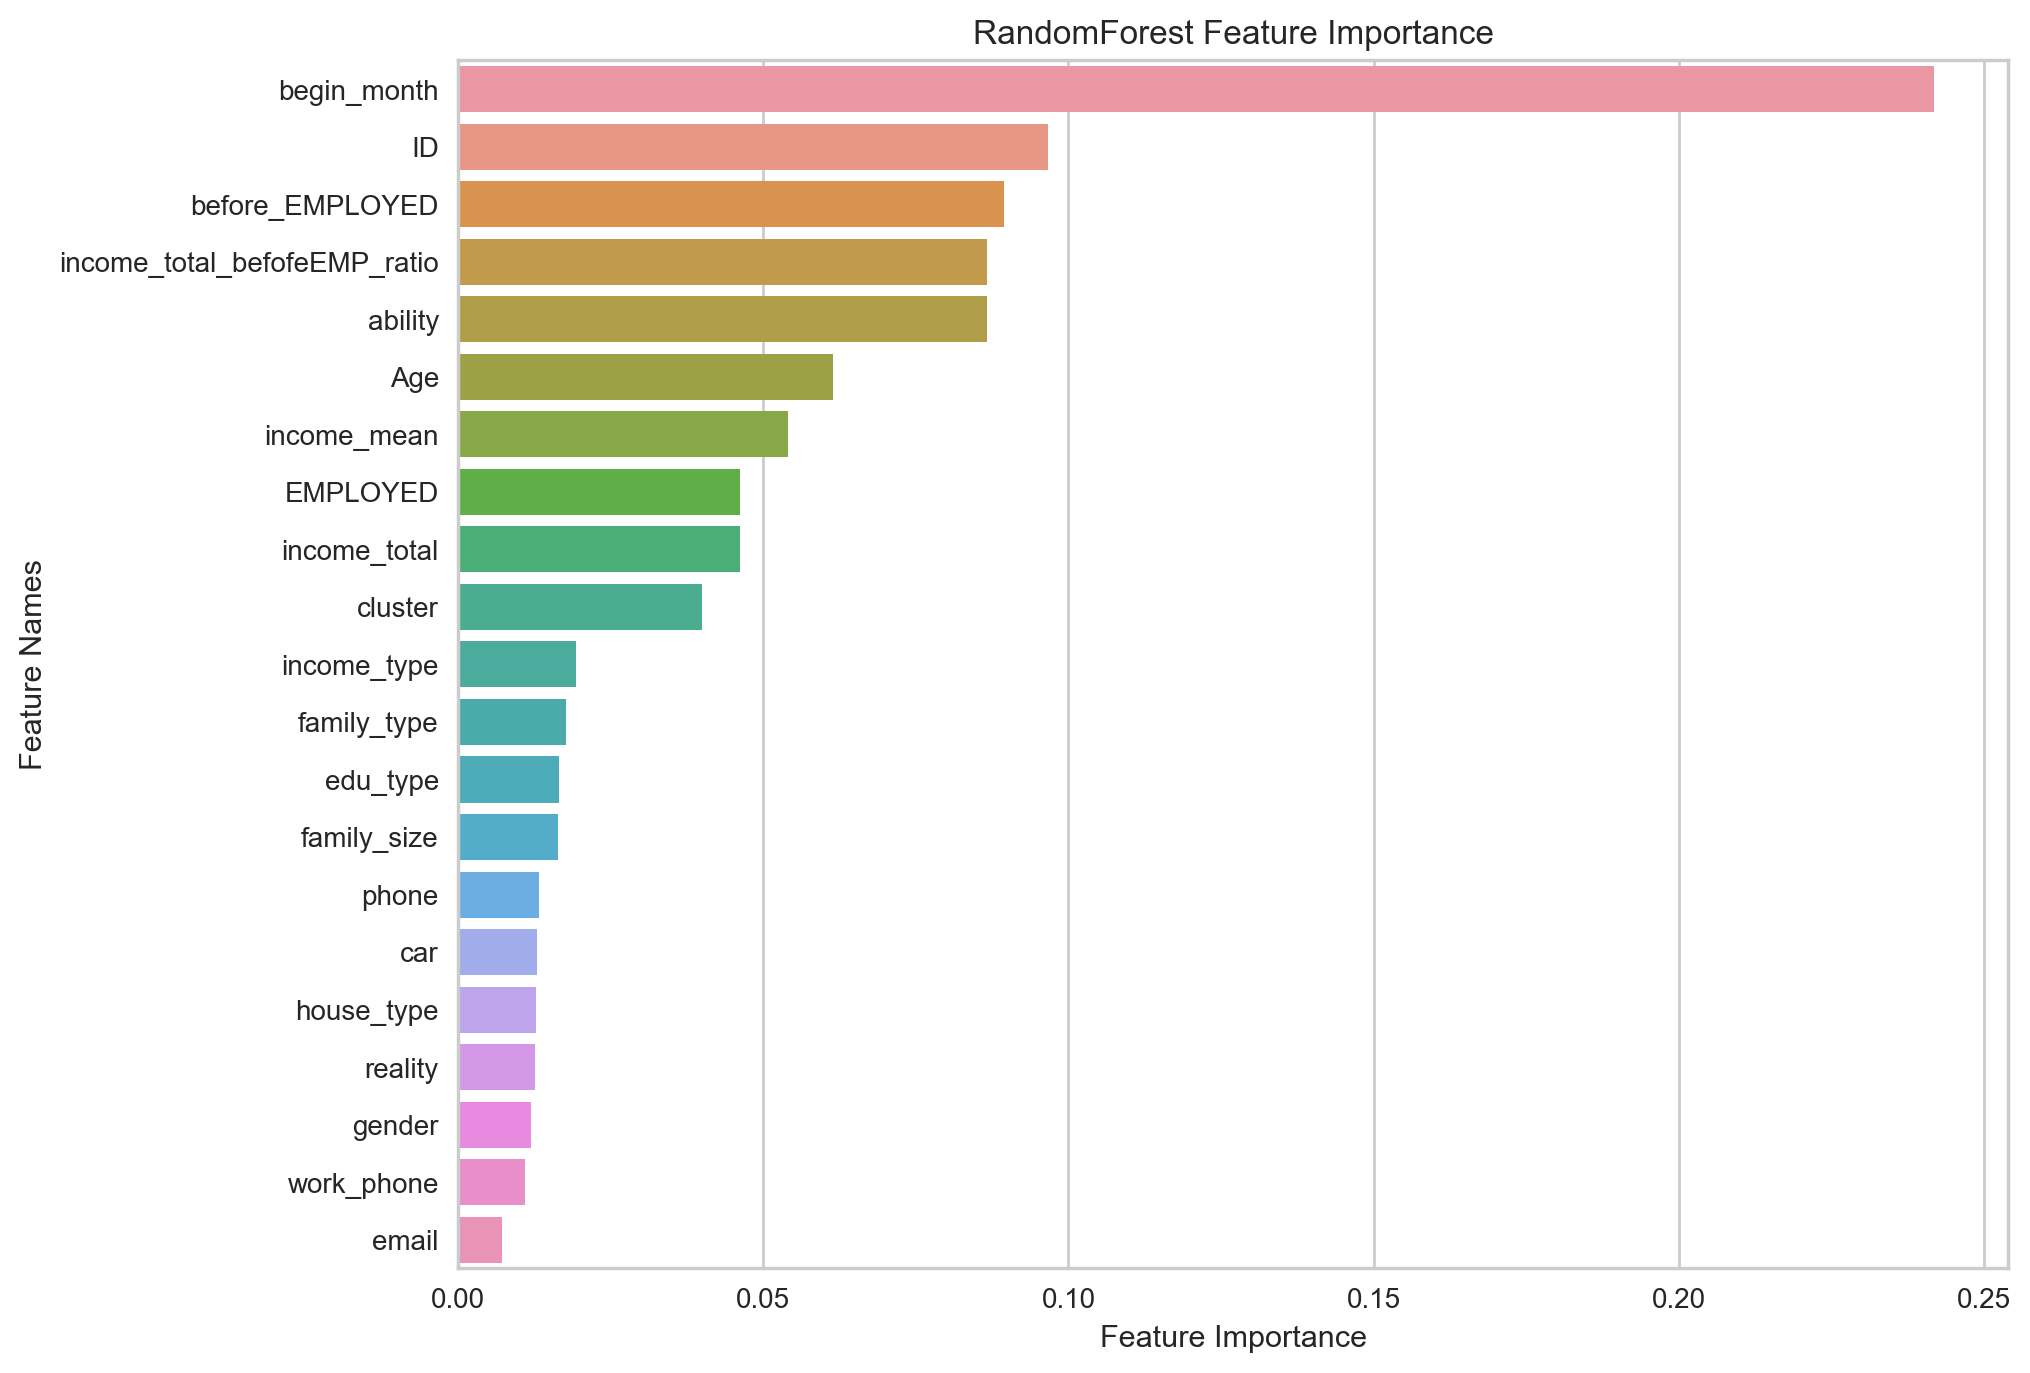

In [38]:
plot_feature_importance(model_rf.feature_importances_,X_test.columns,'RandomForest')

### 3. XGBoost

+ HyperParameter Tuning

In [26]:
def objective(trial: Trial) -> float:
    params_xgb = {
        "random_state": 42,
        "n_estimators": 10000,
        "eta": trial.suggest_float("eta", 0.01, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "max_leaves": trial.suggest_int("max_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 5, 100),
        "gamma": trial.suggest_float("gamma", 0.1, 1.0),
        "objective": "multi:softmax",
        "eval_metric": "mlogloss"
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

    model = XGBClassifier(**params_xgb)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=100,
        verbose=False,
    )

    xgb_pred = model.predict_proba(X_valid)
    log_score = log_loss(y_valid, xgb_pred)
    
    return log_score

In [27]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-01-26 23:36:29,561] A new study created in memory with name: xgb_parameter_opt
[I 2022-01-26 23:36:57,359] Trial 0 finished with value: 0.7582576887534576 and parameters: {'eta': 0.3807947176588889, 'reg_alpha': 2.8521922049233386e-05, 'reg_lambda': 0.06587945744308704, 'max_depth': 12, 'max_leaves': 41, 'colsample_bytree': 0.49359671220172163, 'subsample': 0.3406585285177396, 'min_child_weight': 87.28673384861884, 'gamma': 0.6410035105688879}. Best is trial 0 with value: 0.7582576887534576.
[I 2022-01-26 23:37:14,426] Trial 1 finished with value: 0.7695575726520044 and parameters: {'eta': 0.710991852018085, 'reg_alpha': 6.273289839311154e-07, 'reg_lambda': 0.08729188699548096, 'max_depth': 17, 'max_leaves': 56, 'colsample_bytree': 0.5090949803242604, 'subsample': 0.4283831568974037, 'min_child_weight': 33.90301308115608, 'gamma': 0.5722807884690141}. Best is trial 0 with value: 0.7582576887534576.
[I 2022-01-26 23:37:53,297] Trial 2 finished with value: 0.7334201829525548 and 

Best Score: 0.6914418387414926
Best trial: {'eta': 0.015466895952366375, 'reg_alpha': 2.4465688239360478e-05, 'reg_lambda': 0.0636171638777121, 'max_depth': 15, 'max_leaves': 198, 'colsample_bytree': 0.44442679104045424, 'subsample': 0.5509260099809907, 'min_child_weight': 16.00756065488732, 'gamma': 0.8767930832880342}


+ XGB Train

In [28]:
params = {'random_state': 42,
          'n_estimators': 10000,
          'eta': 0.015466895952366375, 
          'reg_alpha': 2.4465688239360478e-05, 
          'reg_lambda': 0.0636171638777121, 
          'max_depth': 15, 
          'max_leaves': 198, 
          'colsample_bytree': 0.44442679104045424, 
          'subsample': 0.5509260099809907, 
          'min_child_weight': 16.00756065488732, 
          'gamma': 0.8767930832880342,
          'objective': "multi:softmax",
          'eval_metric': "mlogloss"
}

In [29]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

xgb_pred = np.zeros((X.shape[0], n_class))
xgb_pred_test = np.zeros((X_test.shape[0], n_class))
for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]

    model_xgb = XGBClassifier(**params)
    model_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], early_stopping_rounds=100, verbose=100)
  
    xgb_pred[valid_idx] = model_xgb.predict_proba(X_valid)
    xgb_pred_test += model_xgb.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, xgb_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, xgb_pred):.6f}')


----------------- Fold 0 -----------------

[0]	validation_0-mlogloss:1.09237	validation_1-mlogloss:1.09280
[100]	validation_0-mlogloss:0.77369	validation_1-mlogloss:0.80880
[200]	validation_0-mlogloss:0.68818	validation_1-mlogloss:0.74936
[300]	validation_0-mlogloss:0.64144	validation_1-mlogloss:0.72491
[400]	validation_0-mlogloss:0.60631	validation_1-mlogloss:0.70900
[500]	validation_0-mlogloss:0.57762	validation_1-mlogloss:0.69801
[600]	validation_0-mlogloss:0.55354	validation_1-mlogloss:0.68985
[700]	validation_0-mlogloss:0.53236	validation_1-mlogloss:0.68328
[800]	validation_0-mlogloss:0.51438	validation_1-mlogloss:0.67915
[900]	validation_0-mlogloss:0.49832	validation_1-mlogloss:0.67520
[1000]	validation_0-mlogloss:0.48416	validation_1-mlogloss:0.67209
[1100]	validation_0-mlogloss:0.47144	validation_1-mlogloss:0.66987
[1200]	validation_0-mlogloss:0.46012	validation_1-mlogloss:0.66775
[1300]	validation_0-mlogloss:0.44901	validation_1-mlogloss:0.66657
[1400]	validation_0-mlogloss:

[1100]	validation_0-mlogloss:0.47097	validation_1-mlogloss:0.69402
[1200]	validation_0-mlogloss:0.45842	validation_1-mlogloss:0.69389
[1233]	validation_0-mlogloss:0.45460	validation_1-mlogloss:0.69384
CV Log Loss Score: 0.693612

----------------- Fold 7 -----------------

[0]	validation_0-mlogloss:1.09229	validation_1-mlogloss:1.09287
[100]	validation_0-mlogloss:0.77823	validation_1-mlogloss:0.82136
[200]	validation_0-mlogloss:0.68820	validation_1-mlogloss:0.76521
[300]	validation_0-mlogloss:0.63924	validation_1-mlogloss:0.74377
[400]	validation_0-mlogloss:0.60329	validation_1-mlogloss:0.73120
[500]	validation_0-mlogloss:0.57450	validation_1-mlogloss:0.72240
[600]	validation_0-mlogloss:0.55090	validation_1-mlogloss:0.71685
[700]	validation_0-mlogloss:0.53026	validation_1-mlogloss:0.71290
[800]	validation_0-mlogloss:0.51272	validation_1-mlogloss:0.71031
[900]	validation_0-mlogloss:0.49709	validation_1-mlogloss:0.70807
[1000]	validation_0-mlogloss:0.48251	validation_1-mlogloss:0.70649
[

[800]	validation_0-mlogloss:0.51370	validation_1-mlogloss:0.69707
[900]	validation_0-mlogloss:0.49816	validation_1-mlogloss:0.69448
[1000]	validation_0-mlogloss:0.48364	validation_1-mlogloss:0.69269
[1100]	validation_0-mlogloss:0.47106	validation_1-mlogloss:0.69131
[1200]	validation_0-mlogloss:0.45890	validation_1-mlogloss:0.69043
[1300]	validation_0-mlogloss:0.44763	validation_1-mlogloss:0.68963
[1400]	validation_0-mlogloss:0.43784	validation_1-mlogloss:0.68957
[1412]	validation_0-mlogloss:0.43659	validation_1-mlogloss:0.68948
CV Log Loss Score: 0.689396
	Log Loss: 0.695227


+ Feautre Importance

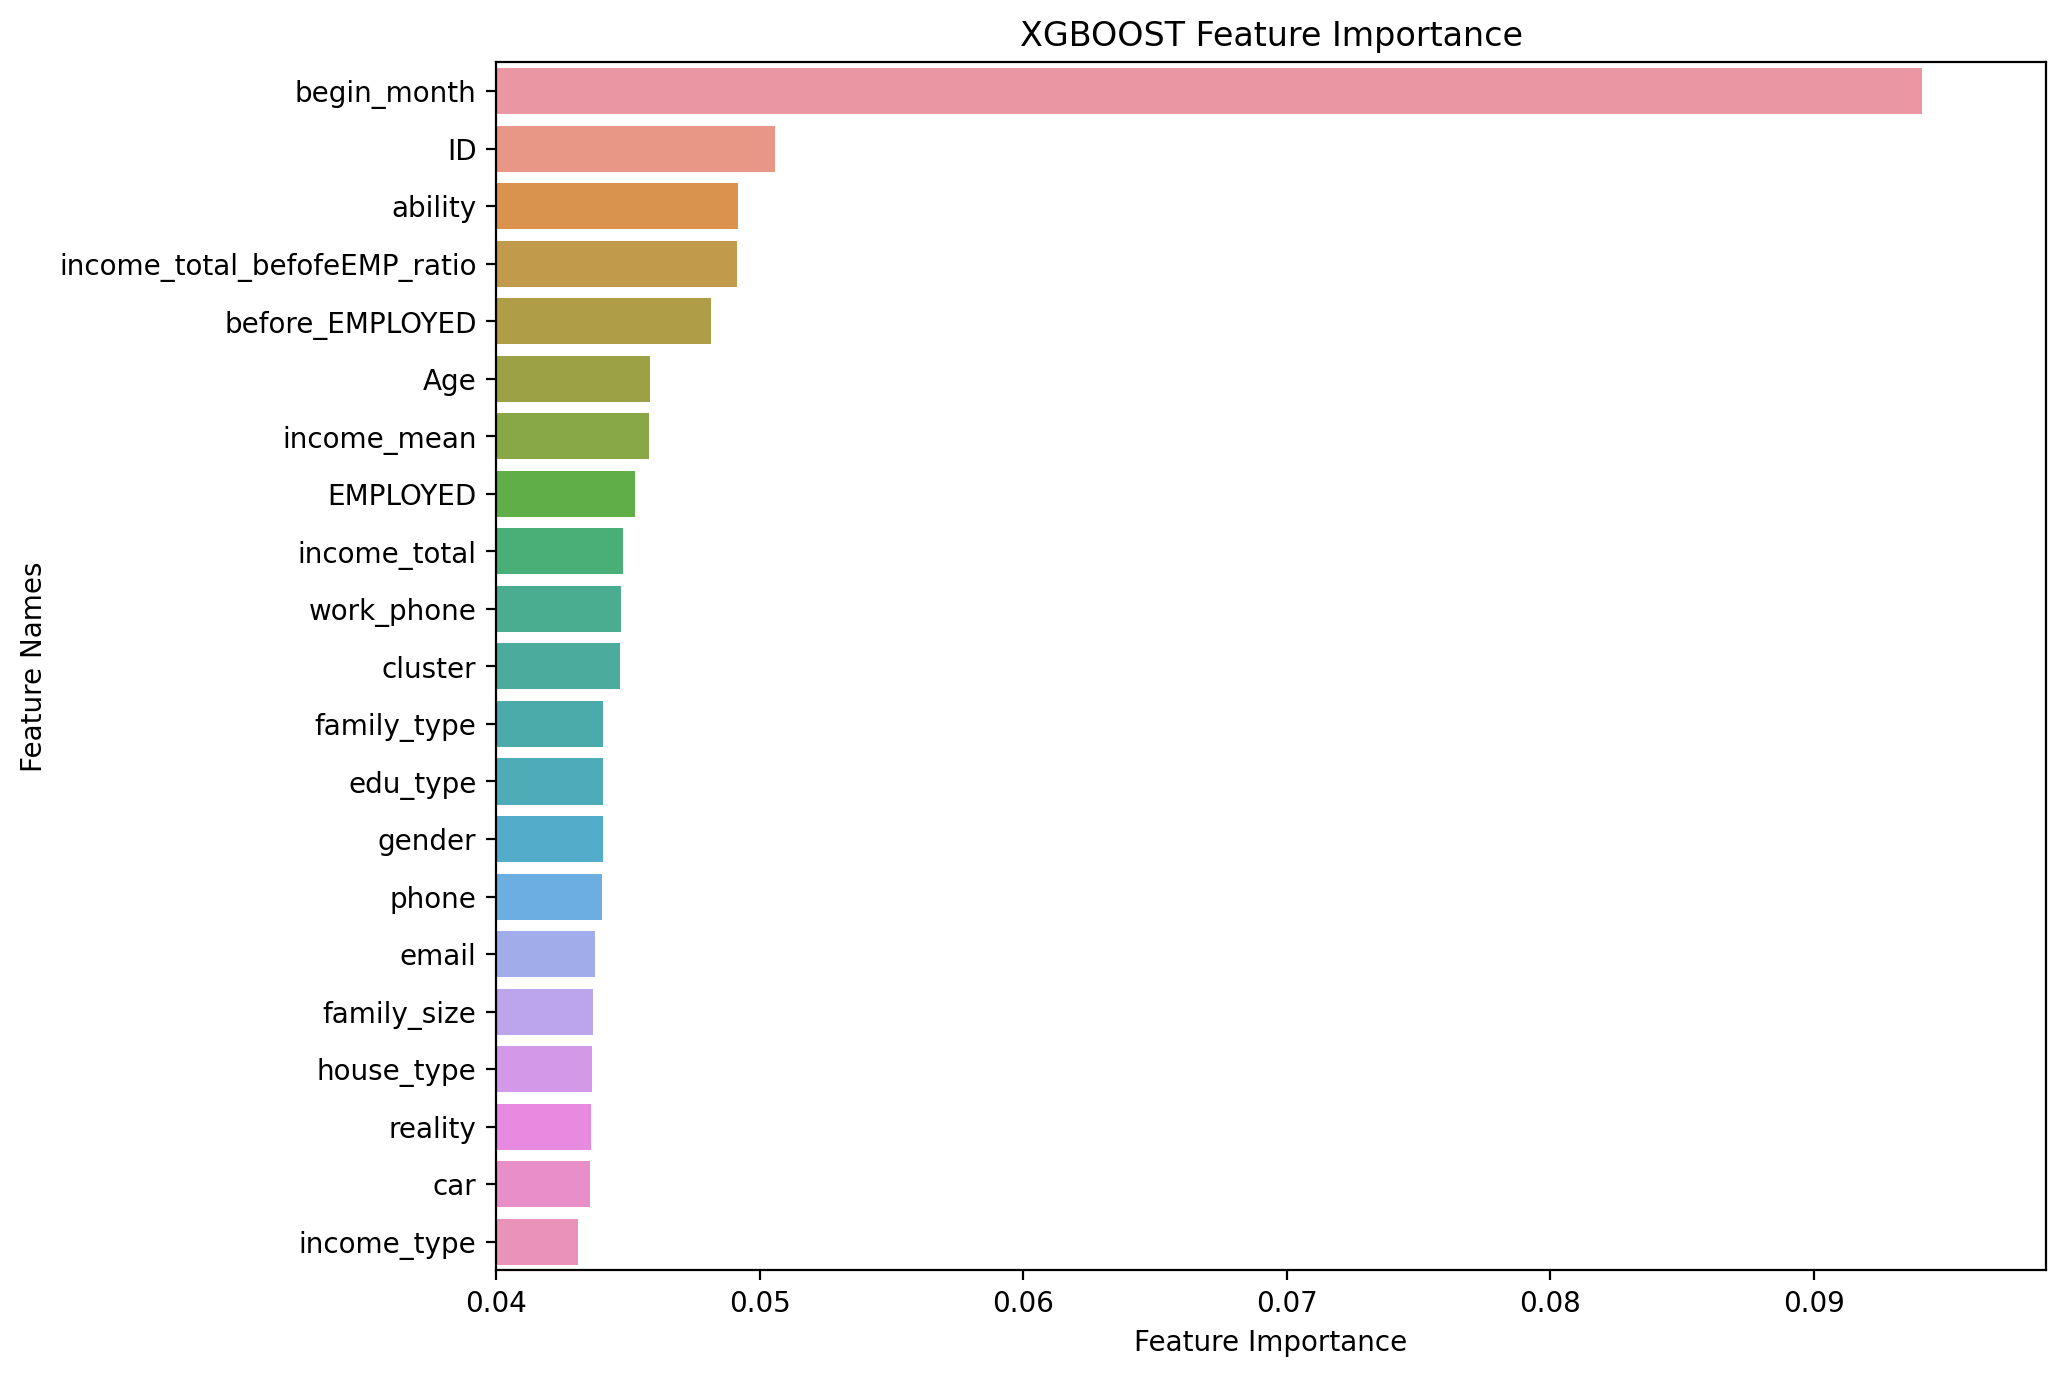

In [30]:
# catboost code 사용했을 때 (plot_importance 함수에 importance_type='gain'을 적용했을 때와 동일)
plot_feature_importance(model_xgb.feature_importances_,X_test.columns,'XGBOOST')
plt.xlim(0.04,);

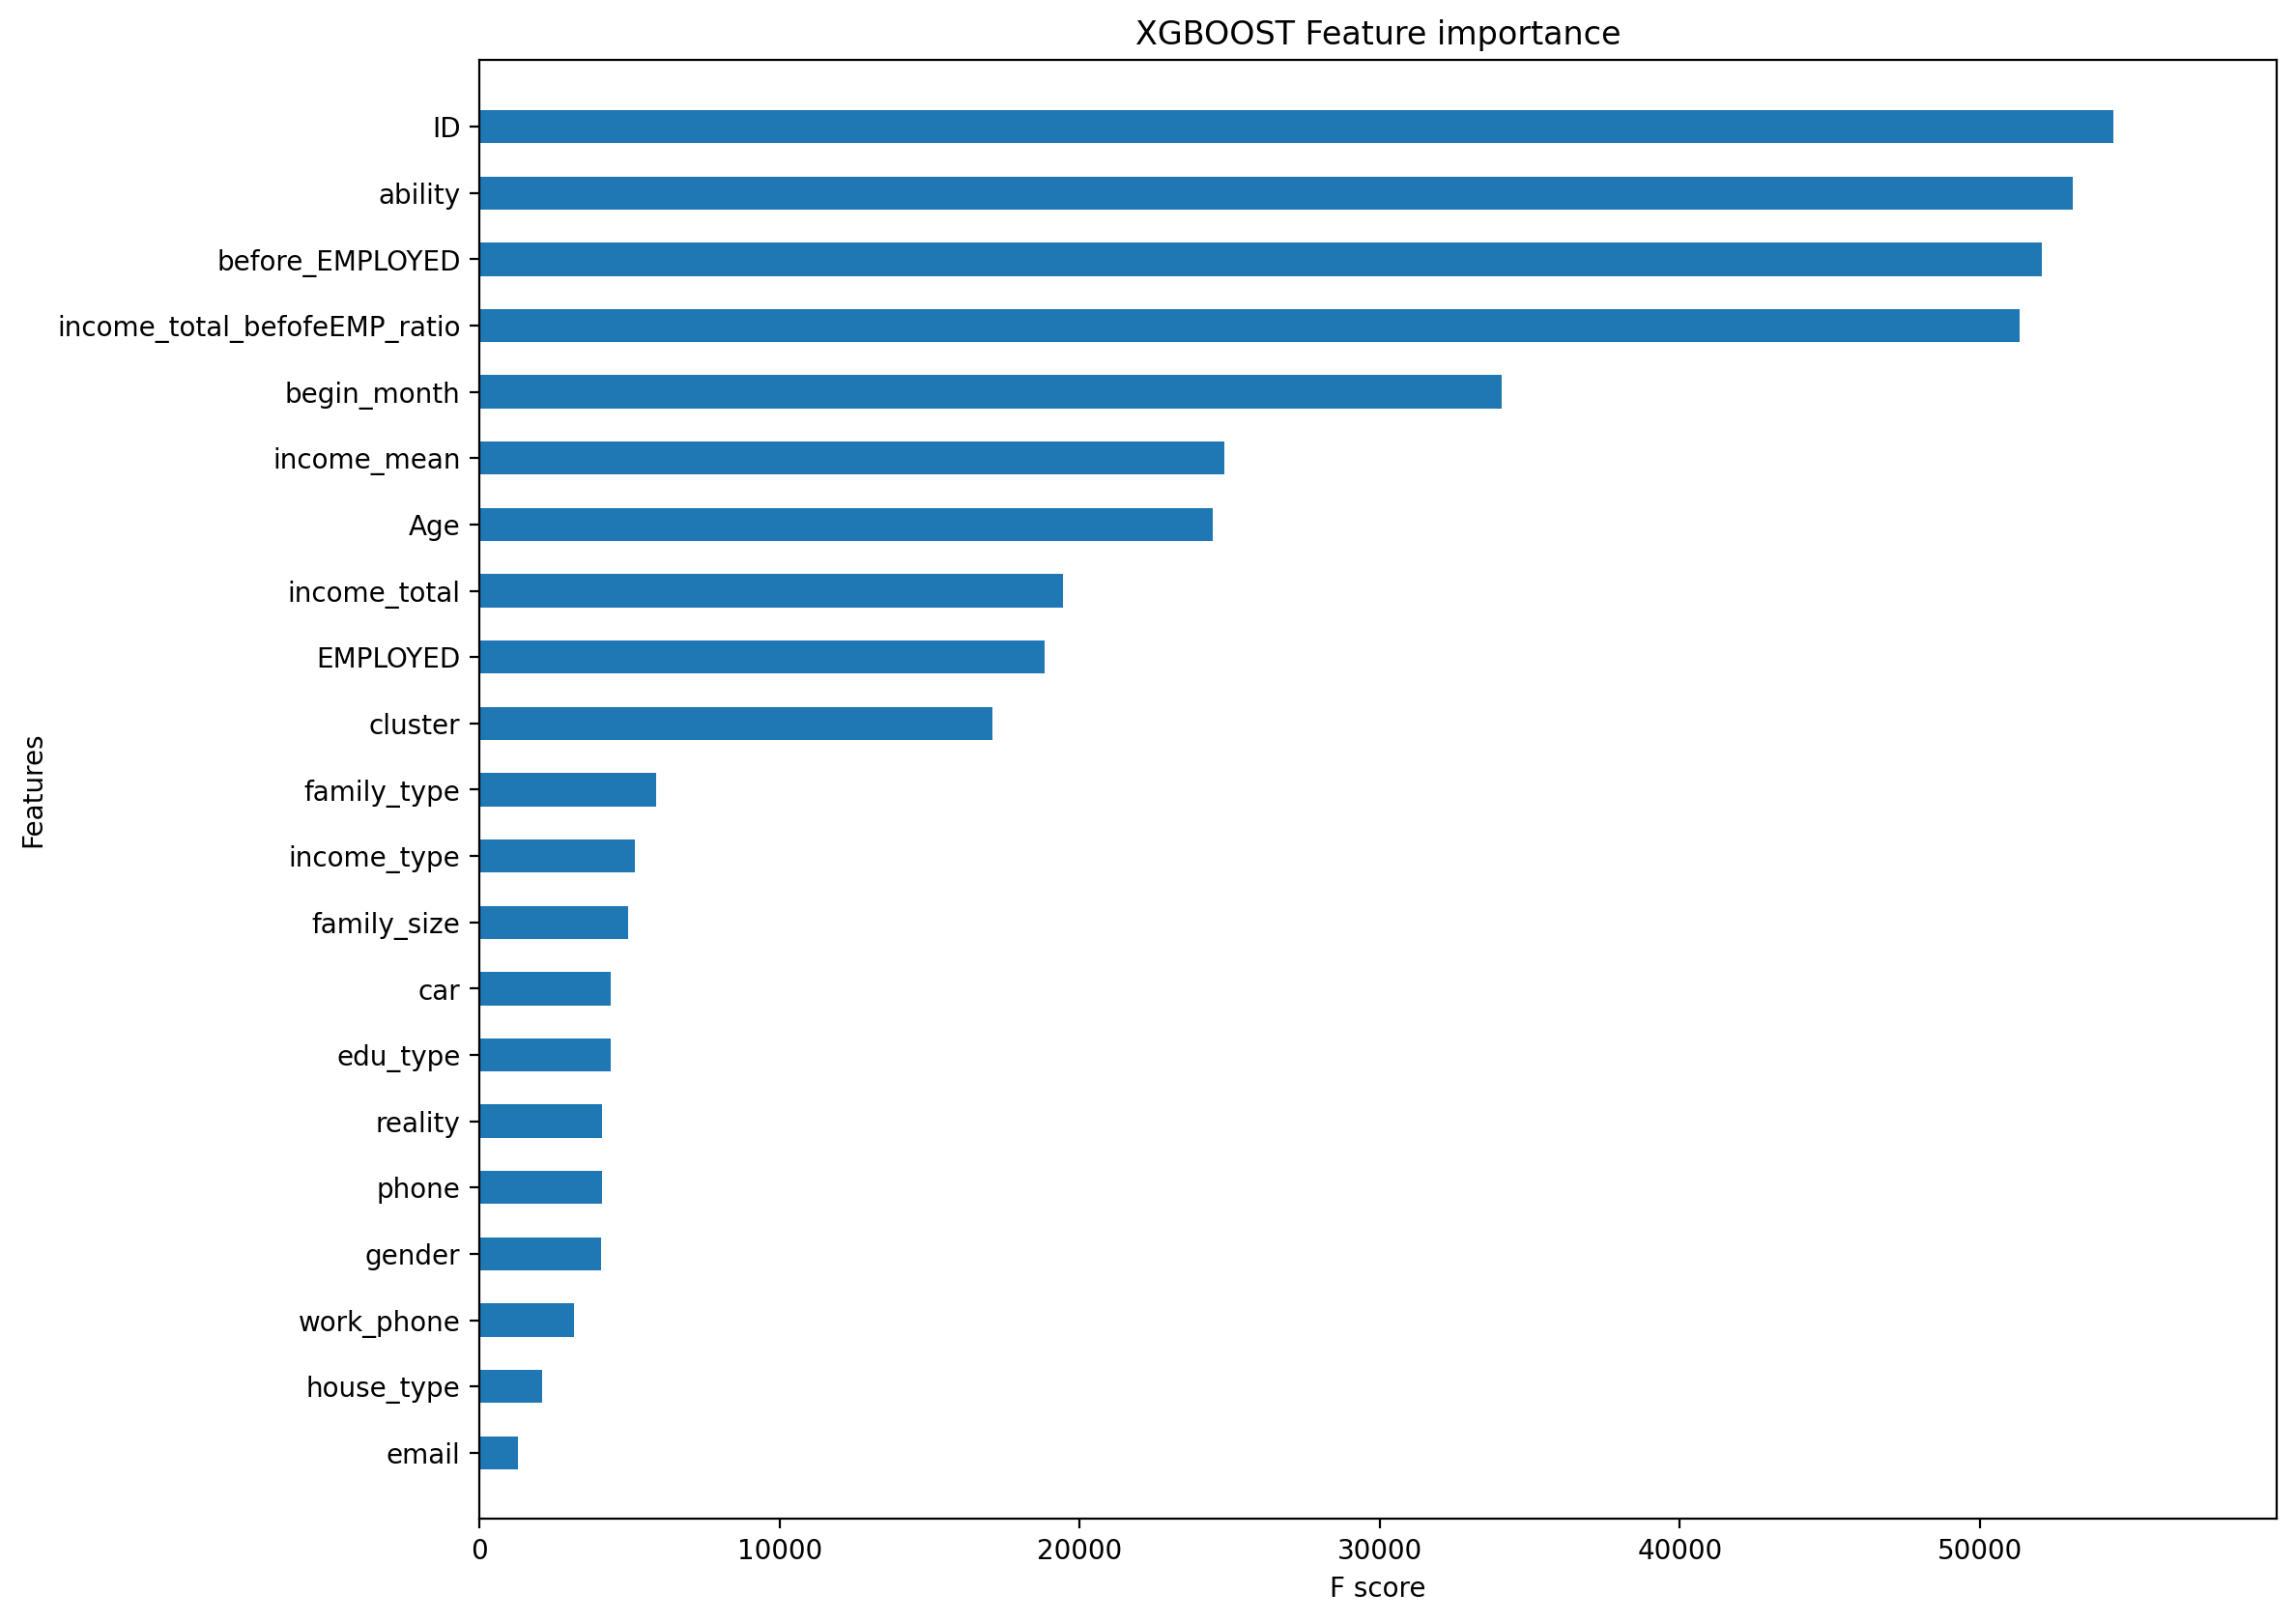

In [31]:
# plot_importance 함수 사용했을 때 (default가 importance_type='weight')
fig, ax = plt.subplots(figsize=(12, 10))
plot_importance(model_xgb, ax=ax, 
                height=0.5, title='XGBOOST Feature importance', grid=False, show_values=False);

### 4. LightGBM

In [32]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

X_features = np.array(train.iloc[:, :-1])
y_labels = np.array(train.iloc[:, -1])
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=2000)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

lgbm = LGBMClassifier(n_estimators=1000)

evals = [(X_test, y_test)]

#모델 학습
lgbm.fit(X_train, y_train, eval_set=evals, early_stopping_rounds=30, verbose=100)

#모델 예측
lgbm_preds = lgbm.predict(X_test)
lgbm_pred_proba = lgbm.predict_proba(X_test)

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred, average='macro')
    recall = recall_score(y_test , pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    roc_auc = roc_auc_score(y_test, pred_proba,multi_class='ovo')
    
    #오차 행렬 출력
    print('오차 행렬')
    print(confusion)
    
    #정확도, 정밀도, 재현율, roc auc score 출력
    print('정확도: {0:.4f}'.format(accuracy))
    print('정밀도: {0:.4f}'.format(precision))
    print('재현율: {0:.4f}'.format(recall))
    print('F1: {0:.4f}'.format(f1))
    print('ROC AUC: {0:.4f}'.format(roc_auc))

In [34]:
lgbm.score(X_train, y_train)

0.9934782608695653

In [35]:
lgbm.score(X_test, y_test)

0.9113589113589113

In [36]:
get_clf_eval(y_test, lgbm_preds, lgbm_pred_proba)

오차 행렬
[[  9   0   0 ...   0   0   0]
 [  0 103   0 ...   0   0   0]
 [  0   0   2 ...   0   0   0]
 ...
 [  0   0   0 ...  95   0   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   0  50]]
정확도: 0.9114
정밀도: 0.8115
재현율: 0.8292
F1: 0.8075
ROC AUC: 0.9003


### 5. Extra Trees  

In [37]:
from sklearn.ensemble import ExtraTreesClassifier

In [60]:
def ET_objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 100)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 1000)
    n_estimators =  trial.suggest_int('n_estimators', 100, 500)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
    
    et = ExtraTreesClassifier(max_depth = max_depth, max_leaf_nodes = max_leaf_nodes,
                              n_estimators = n_estimators,n_jobs=-1,random_state=42)
    
    et.fit(X_train, y_train)    
    et_pred = et.predict_proba(X_valid)
    log_score = log_loss(y_valid, et_pred)
    
    return log_score

#Execute optuna and set hyperparameters
ET_study = optuna.create_study(direction='minimize')
ET_study.optimize(ET_objective, n_trials=20)
print("Best Score:", ET_study.best_value)
print("Best trial:", ET_study.best_trial.params)

[I 2022-01-27 00:50:24,393] A new study created in memory with name: no-name-6efdd862-dd09-41f0-b299-eeef7437af08
[I 2022-01-27 00:50:25,274] Trial 0 finished with value: 0.8667412026019292 and parameters: {'max_depth': 73, 'max_leaf_nodes': 9, 'n_estimators': 139}. Best is trial 0 with value: 0.8667412026019292.
[I 2022-01-27 00:50:26,790] Trial 1 finished with value: 0.7855571086124964 and parameters: {'max_depth': 46, 'max_leaf_nodes': 710, 'n_estimators': 164}. Best is trial 1 with value: 0.7855571086124964.
[I 2022-01-27 00:50:28,295] Trial 2 finished with value: 0.8460394857061907 and parameters: {'max_depth': 97, 'max_leaf_nodes': 105, 'n_estimators': 202}. Best is trial 1 with value: 0.7855571086124964.
[I 2022-01-27 00:50:30,474] Trial 3 finished with value: 0.8296580909523447 and parameters: {'max_depth': 37, 'max_leaf_nodes': 113, 'n_estimators': 307}. Best is trial 1 with value: 0.7855571086124964.
[I 2022-01-27 00:50:33,194] Trial 4 finished with value: 0.8540747369898054 

Best Score: 0.7760391691297854
Best trial: {'max_depth': 61, 'max_leaf_nodes': 982, 'n_estimators': 339}


- ET Train

In [61]:
params = {'max_depth': 68, 'max_leaf_nodes': 979, 'n_estimators': 488, 'n_jobs':-1, 'random_state':42}

In [62]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

et_pred = np.zeros((X.shape[0], n_class))
et_pred_test = np.zeros((X_test.shape[0], n_class))
for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]

    model_et = ExtraTreesClassifier(**params)
    model_et.fit(X_train, y_train)
  
    et_pred[valid_idx] = model_et.predict_proba(X_valid)
    et_pred_test += model_et.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, et_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, et_pred):.6f}')


----------------- Fold 0 -----------------

CV Log Loss Score: 0.763111

----------------- Fold 1 -----------------

CV Log Loss Score: 0.782537

----------------- Fold 2 -----------------

CV Log Loss Score: 0.780259

----------------- Fold 3 -----------------

CV Log Loss Score: 0.769193

----------------- Fold 4 -----------------

CV Log Loss Score: 0.776781

----------------- Fold 5 -----------------

CV Log Loss Score: 0.775817

----------------- Fold 6 -----------------

CV Log Loss Score: 0.767921

----------------- Fold 7 -----------------

CV Log Loss Score: 0.774068

----------------- Fold 8 -----------------

CV Log Loss Score: 0.777974

----------------- Fold 9 -----------------

CV Log Loss Score: 0.777243

----------------- Fold 10 -----------------

CV Log Loss Score: 0.776959

----------------- Fold 11 -----------------

CV Log Loss Score: 0.787058

----------------- Fold 12 -----------------

CV Log Loss Score: 0.770282

----------------- Fold 13 -----------------

CV

- Feature Importance 

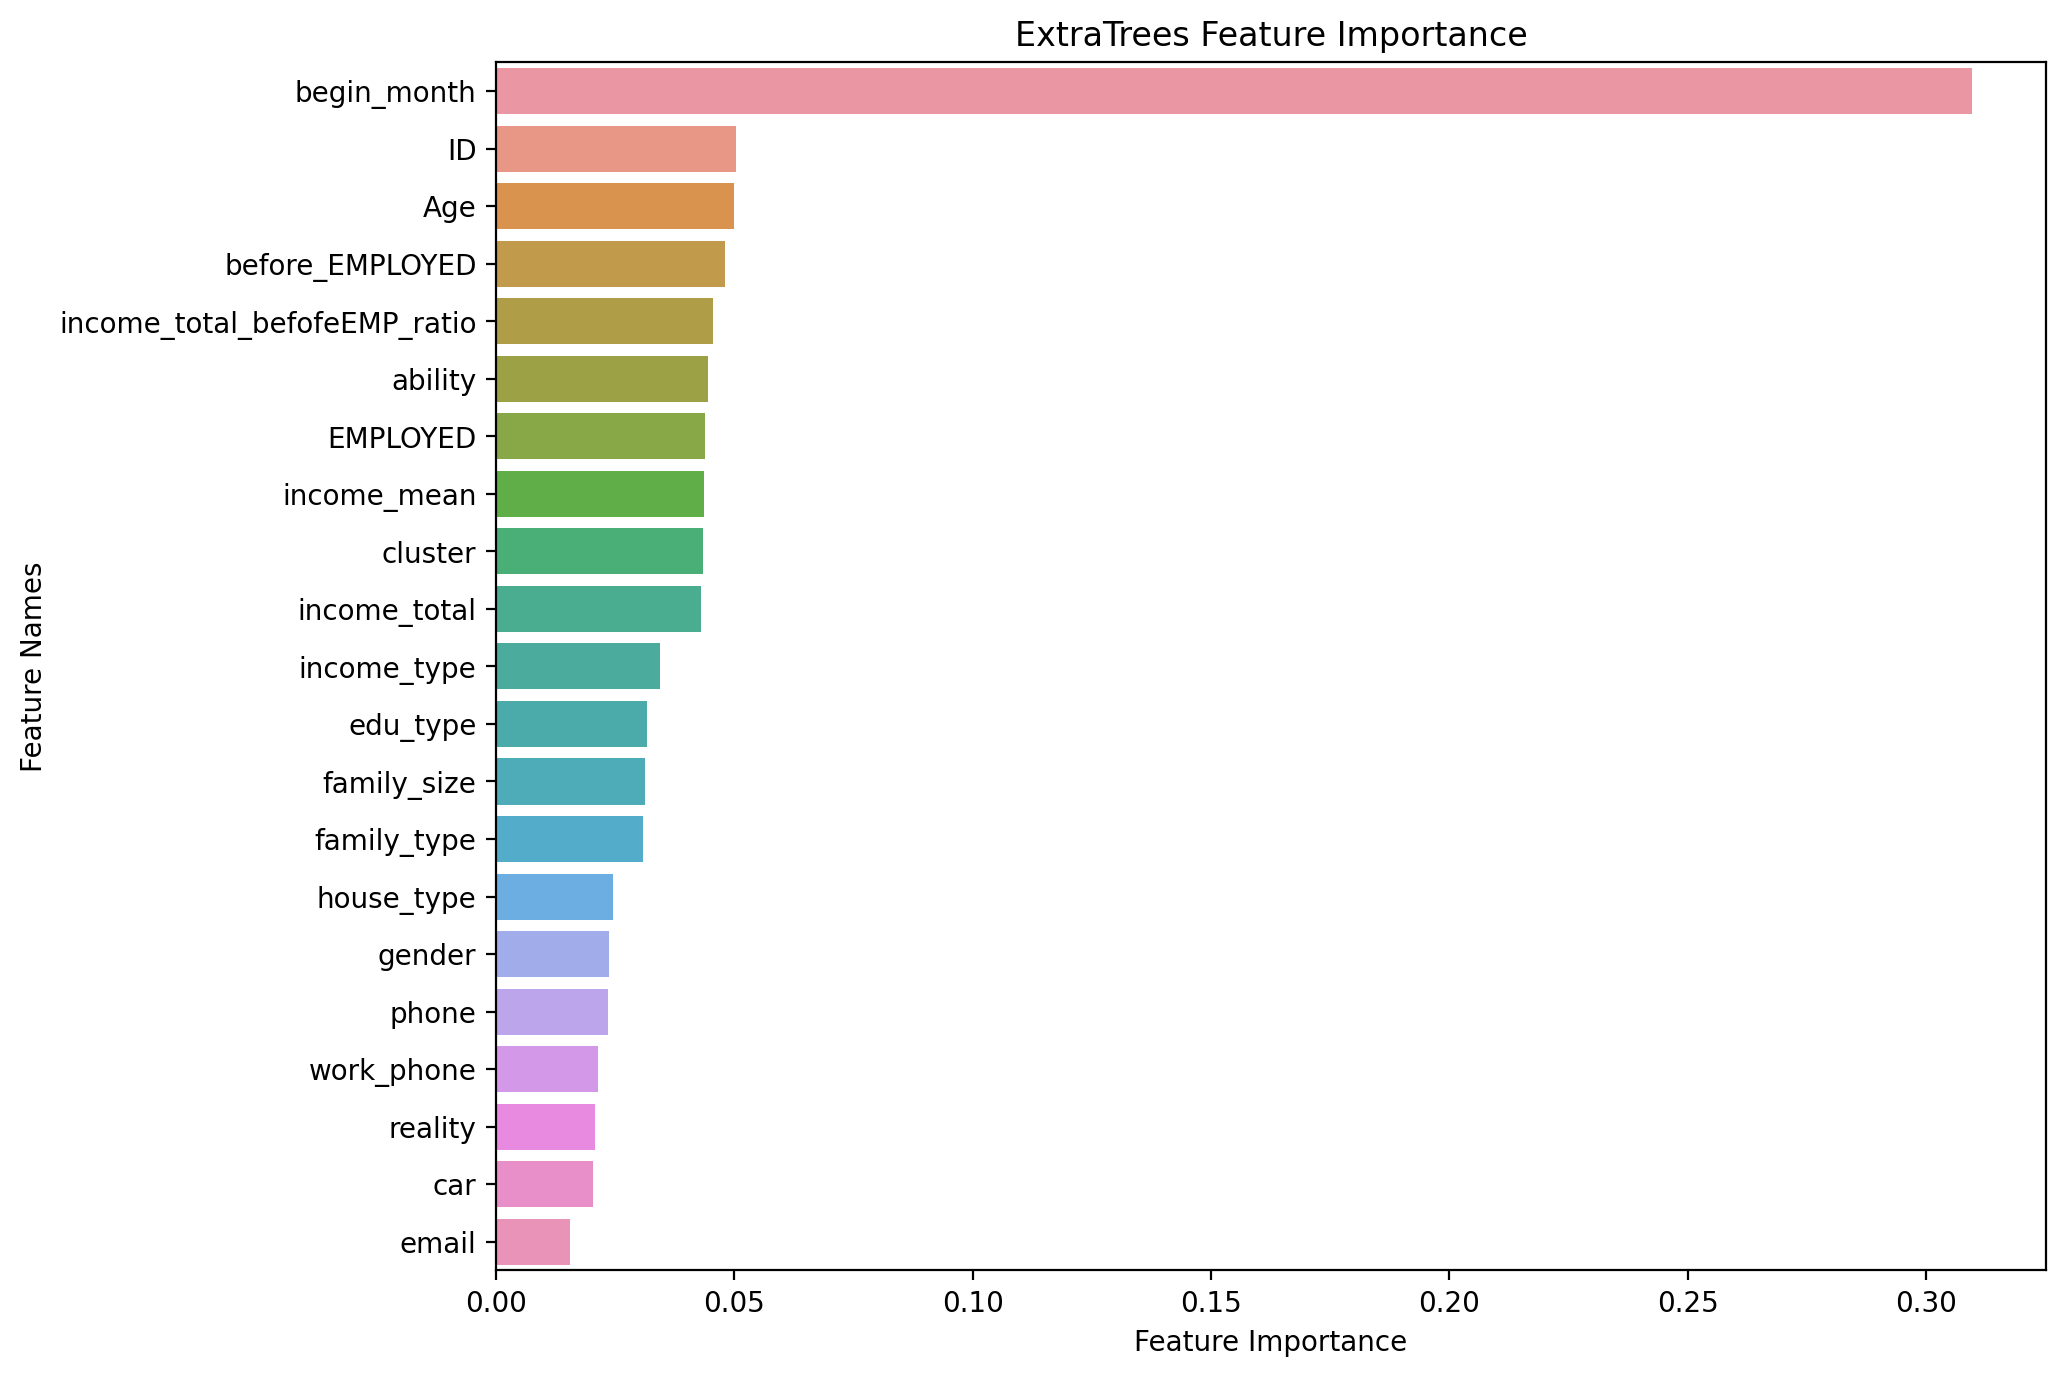

In [63]:
plot_feature_importance(model_et.feature_importances_,X_test.columns,'ExtraTrees')

### 6. CatBoost

+ Cat Train

In [64]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'ID']
for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    model_cat = CatBoostClassifier()
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')



----------------- Fold 0 -----------------

Learning rate set to 0.115127
0:	learn: 1.0356108	test: 1.0341263	best: 1.0341263 (0)	total: 85.2ms	remaining: 1m 25s
100:	learn: 0.7058846	test: 0.6406679	best: 0.6405963 (95)	total: 11.8s	remaining: 1m 44s
200:	learn: 0.6884212	test: 0.6388994	best: 0.6383078 (160)	total: 24.6s	remaining: 1m 37s
300:	learn: 0.6737623	test: 0.6382004	best: 0.6381507 (263)	total: 37s	remaining: 1m 25s
400:	learn: 0.6570974	test: 0.6404526	best: 0.6381466 (307)	total: 49.6s	remaining: 1m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6381465566
bestIteration = 307

Shrink model to first 308 iterations.
CV Log Loss Score: 0.638147

----------------- Fold 1 -----------------

Learning rate set to 0.115127
0:	learn: 1.0355141	test: 1.0347327	best: 1.0347327 (0)	total: 120ms	remaining: 2m
100:	learn: 0.7057441	test: 0.6722904	best: 0.6722572 (99)	total: 10.7s	remaining: 1m 35s
200:	learn: 0.6887329	test: 0.6710111	best: 0.6704440 (193)	t

CV Log Loss Score: 0.681000

----------------- Fold 14 -----------------

Learning rate set to 0.115127
0:	learn: 1.0346629	test: 1.0340549	best: 1.0340549 (0)	total: 114ms	remaining: 1m 54s
100:	learn: 0.7069340	test: 0.6740547	best: 0.6740451 (99)	total: 11.2s	remaining: 1m 39s
200:	learn: 0.6896937	test: 0.6708515	best: 0.6708293 (196)	total: 23.4s	remaining: 1m 32s
300:	learn: 0.6730443	test: 0.6693241	best: 0.6690187 (297)	total: 37.3s	remaining: 1m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6690187263
bestIteration = 297

Shrink model to first 298 iterations.
CV Log Loss Score: 0.669019
	Log Loss: 0.664980


+ Feautre Importance

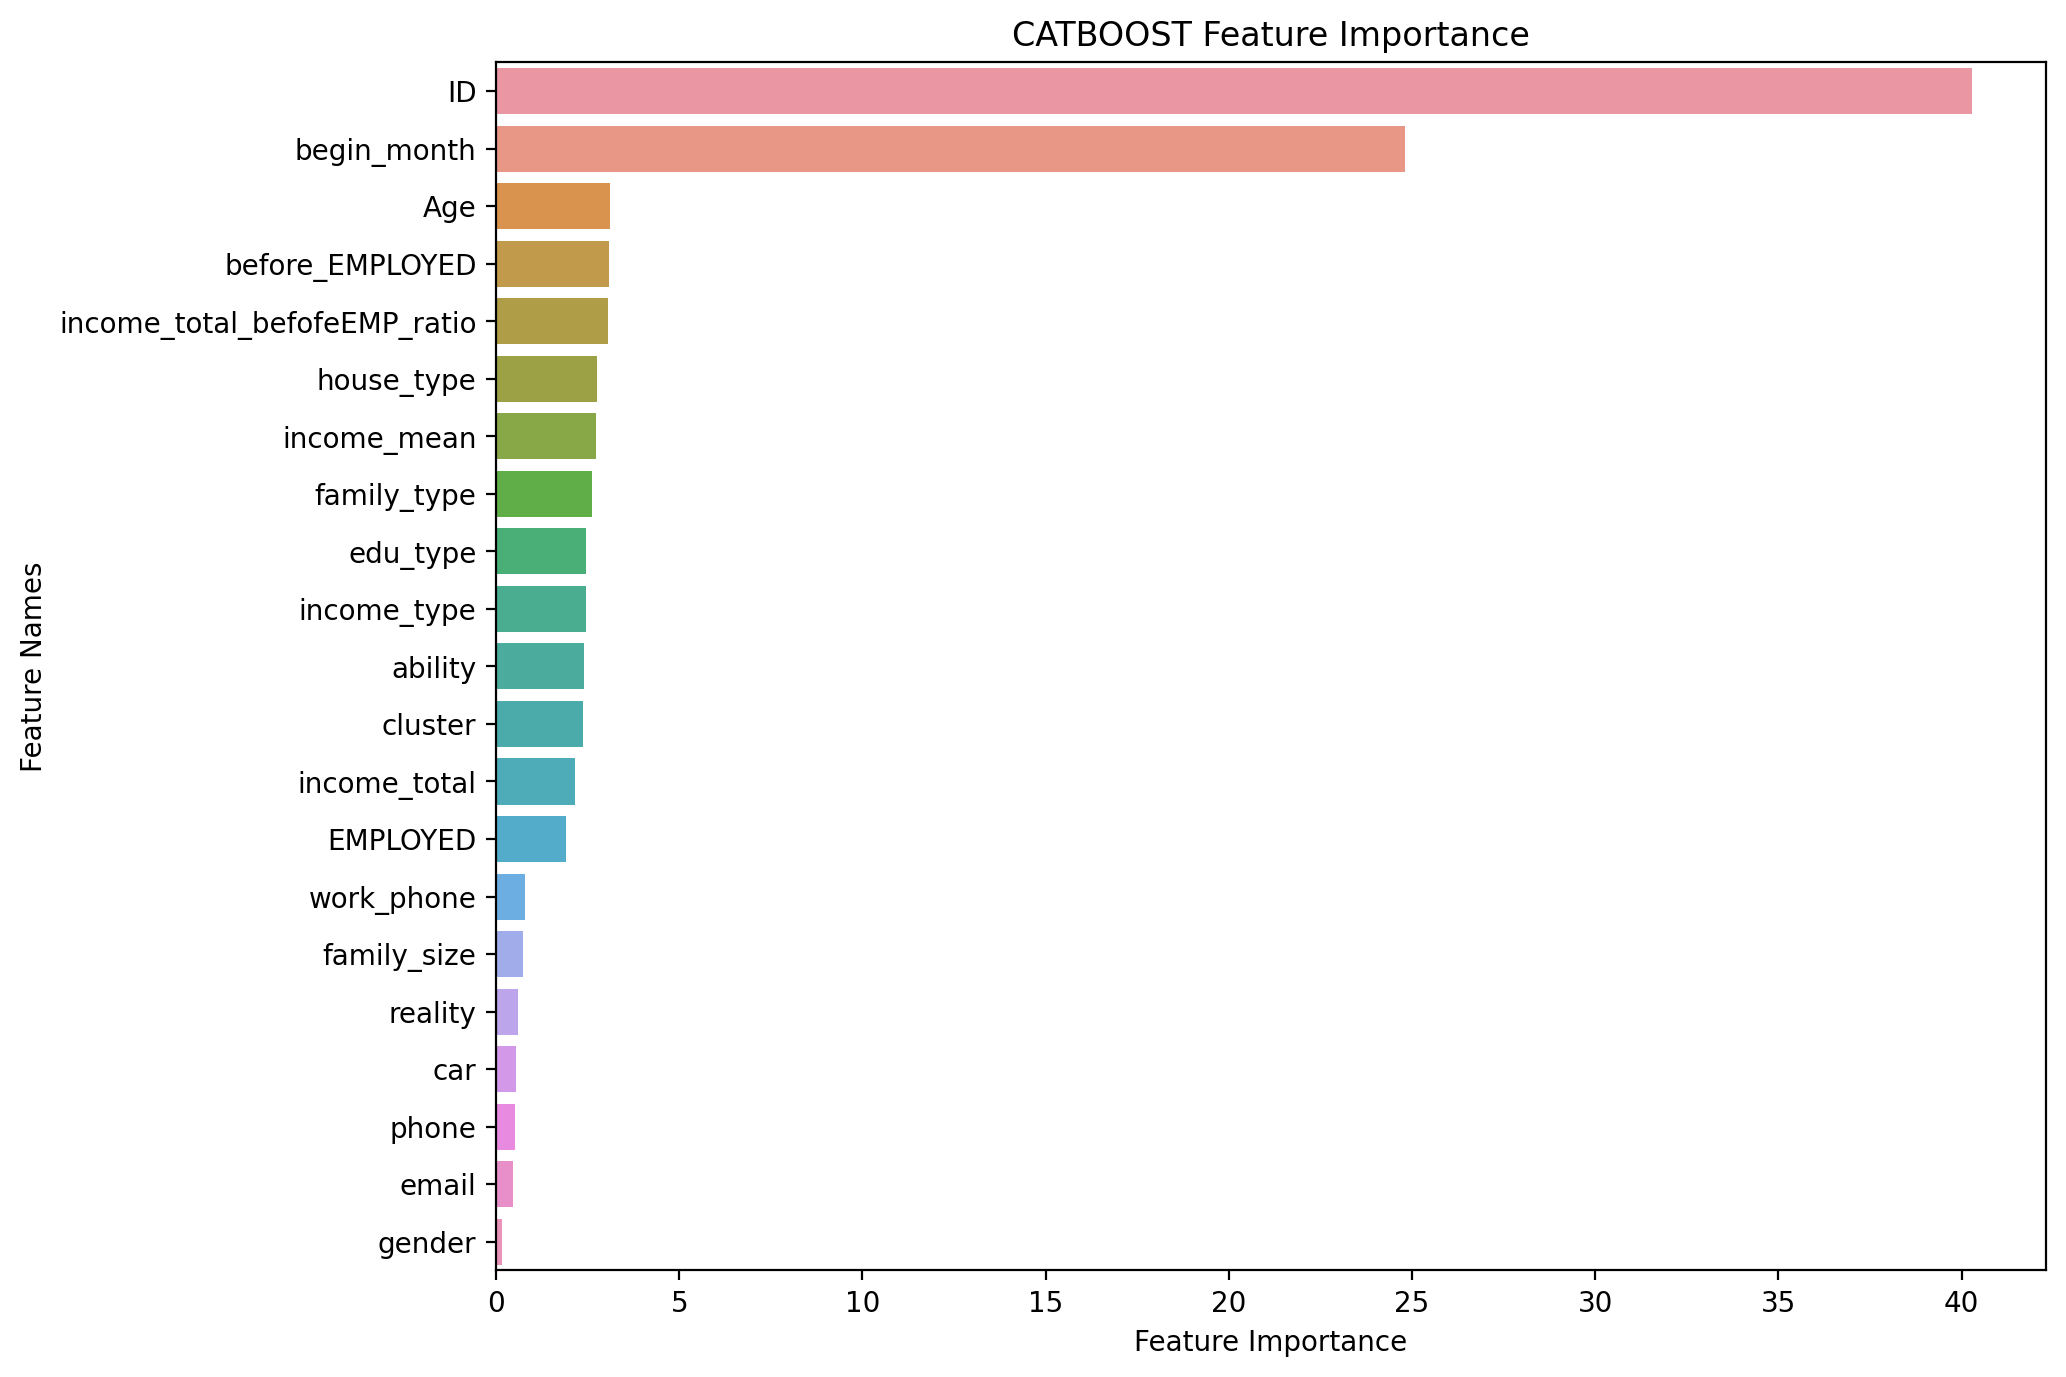

In [65]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

## Submission

### submission 파일 저장

In [66]:
submission.iloc[:, 1:] = cat_pred_test
submission

,index,0,1,2
0,26457,0.112759,0.162719,0.724522
1,26458,0.338165,0.215222,0.446613
2,26459,0.035458,0.071069,0.893473
3,26460,0.054840,0.079469,0.865692
4,26461,0.077606,0.241398,0.680997
...,...,...,...,...
9995,36452,0.077558,0.223193,0.699249
9996,36453,0.331299,0.190689,0.478012
9997,36454,0.040333,0.105692,0.853975
9998,36455,0.145446,0.296716,0.557838


In [68]:
submission.to_csv('sample_submission.csv', index=False)